In [1]:
import datagen
import ocr
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

In [2]:
ocr_module = ocr.OCR(None,None)
model_to_train = ocr_module.name_model
batch_size = 64
text_gen_name_mode = model_to_train is ocr_module.name_model

In [ ]:
import glob
import random

import numpy as np

import ArtsInfo
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageDraw, ImageFont

In [4]:
import itertools
import multiprocessing as mp
import time
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def single_sample_encoder(char_to_num, max_length):
    def encode_single_sample(img, text):
        # 3. Convert to float32 in [0, 1] range
        img = tf.image.convert_image_dtype(img, tf.float32)
        # 5. Transpose the image because we want the time
        # dimension to correspond to the width of the image.
        img = tf.transpose(img, perm=[1, 0, 2])
        # 6. Map the characters in label to numbers
        label = char_to_num(tf.strings.unicode_split(text, input_encoding="UTF-8"))
        label = tf.keras.preprocessing.sequence.pad_sequences(
            [label], maxlen=max_length, padding="post"
        )[0]
        # 7. Return a dict as our model is expecting two inputs
        return img, label
    return encode_single_sample


def data_gen1(q=None):
    np.random.seed(int(q.qsize() + time.time() * 1000) % (2 ** 24))
    text_gens = [
        datagen.gen_name,
        datagen.gen_type,
        datagen.gen_main_attr_name,
        datagen.gen_main_attr_value,
        datagen.gen_level,
        datagen.gen_single_sub_attr,
    ]
    if text_gen_name_mode:
        text_gens = text_gens[:1]
    else:
        text_gens = text_gens[1:]
    for i in itertools.count(1):
        text = np.random.choice(text_gens)()
        img = np.array(ocr_module.preprocess(datagen.generate_image(text)))[:, :, None]
        #         yield img, text
        q.put((img, text))


def data_gen():
    q = mp.Queue(2048)
    pool = [mp.Process(target=data_gen1, args=(q,)) for _ in range(30)]
    [p.start() for p in pool]
    #     for i in data_gen1():
    #         img, text = i
    for i in itertools.count(1):
        img, text = q.get()
        yield img, text

In [5]:
import glob
import json
import os


def load_anno_data(path, skip_empty_attr=True):
    anno_files = glob.glob(path + "/*_anno.json")
    data_ids = [os.path.basename(i).split("_")[0] for i in anno_files]
    img_files = [path + f"/{i}.png" for i in data_ids]
    annos = [json.load(open(i, "r")) for i in anno_files]
    imgs = [ocr_module.extract_art_info(datagen.Image.open(i)) for i in img_files]
    name_mapping = [
        "name",
        "type",
        "level",
        "attr",
        "attr_value",
        "subattr1",
        "subattr2",
        "subattr3",
        "subattr4",
    ]
    name_mapping2 = [
        "name",
        "type",
        "level",
        "main_attr_name",
        "main_attr_value",
        "subattr_1",
        "subattr_2",
        "subattr_3",
        "subattr_4",
    ]
    if text_gen_name_mode:
        name_mapping = name_mapping[:1]
        name_mapping2 = name_mapping2[:1]
    else:
        name_mapping = name_mapping[1:]
        name_mapping2 = name_mapping2[1:]
    result = []
    for file, img, anno in zip(anno_files, imgs, annos):
        for name1, name2 in zip(name_mapping, name_mapping2):
            if not skip_empty_attr or anno[name1]:
                if name1 == "level":
                    anno[name1] = "+" + anno[name1]
                try:
                    result.append((file, ocr_module.preprocess(img[name2], True), anno[name1]))
                except:
                    print(file)
                    raise
    return result

In [6]:
anno_data = load_anno_data("../data/artifacts")


def valid_gen():
    for file, img, label in anno_data:
        yield img[:, :, None], label

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


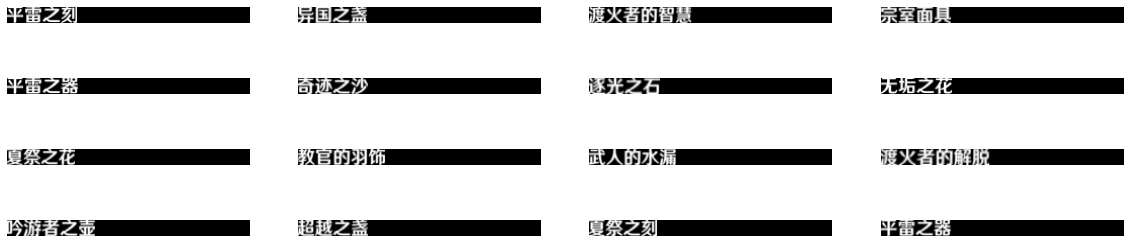

In [7]:
train_dataset = tf.data.Dataset.from_generator(
    data_gen, output_types=(tf.float32, tf.string)
)
train_dataset = (
    train_dataset.map(
        lambda x, y: tf.py_function(
            single_sample_encoder(model_to_train.char_to_num, model_to_train.max_length), [x, y], (tf.float32, tf.int64)
        ),
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_generator(
    valid_gen, output_types=(tf.float32, tf.string)
)
validation_dataset = (
    validation_dataset.map(
        lambda x, y: tf.py_function(
            single_sample_encoder(model_to_train.char_to_num, model_to_train.max_length), [x, y], (tf.float32, tf.int64)
        ),
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

# plt.rcParams["font.sans-serif"] = ["Droid Sans Fallback", "sans-serif"]
_, ax = plt.subplots(4, 4, figsize=(20, 5))
for batch in train_dataset.take(1):
    images = batch[0]
    labels = batch[1]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        #         label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        #         ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

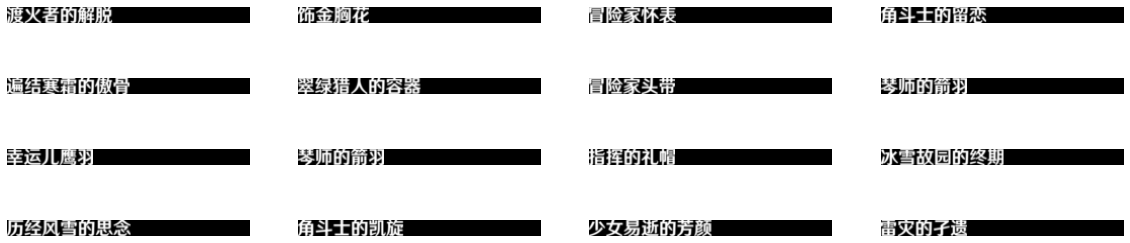

In [8]:
_, ax = plt.subplots(4, 4, figsize=(20, 5))
for batch in validation_dataset.take(1):
    images = batch[0]
    labels = batch[1]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        #         label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        #         ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [9]:
@tf.autograph.experimental.do_not_convert
def ctc_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.math.count_nonzero(y_true, axis=-1, keepdims=True)

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    return keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)


# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :model_to_train.max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = model_to_train.num_to_char(res)
        res = tf.strings.reduce_join(res)
        res = res.numpy().decode("utf-8")
        output_text.append(res)
    return output_text


class CTCAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="ctc_accuracy", **kwargs):
        super(CTCAccuracy, self).__init__(name=name, **kwargs)
        self.correct_count = 0
        self.all_count = 0

    def update_state(self, y_true, y_pred, sample_weight=None):
        pred_text = decode_batch_predictions(y_pred)
        self.all_count += len(pred_text)
        true_text = []
        for res in y_true:
            res = model_to_train.num_to_char(res)
            res = tf.strings.reduce_join(res)
            res = res.numpy().decode("utf-8")
            true_text.append(res)
        self.correct_count += sum([i == j for i, j in zip(pred_text, true_text)])

    def result(self):
        return self.correct_count / self.all_count

    def reset_states(self):
        self.correct_count = 0
        self.all_count = 0

In [10]:
# Get the model
opt = keras.optimizers.Adam()
# Compile the model and return
model_to_train.model.compile(loss=ctc_loss, optimizer=opt, metrics=[CTCAccuracy("ctc_accu")])
model_to_train.model.run_eagerly = True
model_to_train.model.summary()

Model: "ocr_model_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 240, 16, 1)]      0         
_________________________________________________________________
model (Functional)           (None, 30, 2, 576)        2300784   
_________________________________________________________________
reshape (Reshape)            (None, 30, 1152)          0         
_________________________________________________________________
dense1 (Dense)               (None, 30, 64)            73792     
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 256)           197632    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 128)          

In [11]:
epochs = 500
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model_to_train.model.fit(
    train_dataset,
    validation_data=validation_dataset,
    steps_per_epoch=500,
    epochs=epochs,
    callbacks=[early_stopping],
    use_multiprocessing=False,
)

Epoch 1/500
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
500/500 [==============================] - 365s 726ms/step - loss: 30.0979 - ctc_accu: 9.0843e-04 - val_loss: 39.3205 - val_ctc_accu: 0.0000e+00
Epoch 2/500
500/500 [==============================] - 368s 736ms/step - loss: 9.1142 - ctc_accu: 0.0523 - val_loss: 4.4702 - val_ctc_accu: 0.3128
Epoch 3/500
500/500 [==============================] - 366s 733ms/step - loss: 3.7494 - ctc_accu: 0.3995 - val_loss: 1.7395 - val_ctc_accu: 0.7353
Epoch 4/500
500/500 [==============================] - 368s 737ms/step - loss: 1.4807 - ctc_accu: 0.7852 - val_loss: 0.6079 - val_ctc_accu: 0.9064
Epoch 5/500
500/500 [==============================] - 367s 733ms/step - loss: 0.4269 - ctc_accu: 0.97

In [12]:
if text_gen_name_mode:
    model_to_train.model.save_weights('../name_model.h5')
else:
    model_to_train.model.save_weights('../generic_model.h5')